In [1]:
import pandas as pd
import os
import numpy as np

# Calculate Petaluma Recylced water deliveries



In [3]:
data_path = r'T:\arich\SGMA\SGMA_Rate_study\Update 2022\sonoma_co_gsas_rate_fee'

In [4]:
f = os.path.join(data_path, 'pet', 'recycled_water')

In [5]:
file = os.path.join(f, 'input', '2023 City of Petaluma 2016-2023 Recycled Water Use_APN.xlsx')

if os.path.exists(file):
    print(f"file exists:\n\t{file}")
else: 
    raise ValueError(f"file does not exist:\n\t{file}")

file exists:
	T:\arich\SGMA\SGMA_Rate_study\Update 2022\sonoma_co_gsas_rate_fee\pet\recycled_water\input\2023 City of Petaluma 2016-2023 Recycled Water Use_APN.xlsx


# Load, fill, and process the petaluma reycled water data

In [6]:




def replace_apn(df):
    # names to replace old APN's
    rep =     os.path.join(f, 'rename_petaluma_apns.xlsx')
    rep = pd.read_excel(rep).rename(columns = {'APN':'new_APN'})
    
    df = pd.merge(df,rep, left_on = 'Service Location', right_on = 'Service', how = 'left')
    c = df.loc[:,'new_APN'].notnull()
    df.loc[c,'APN'] = df.loc[c,'new_APN']
    
    df = df.drop(columns = ['new_APN', 'Service'])
    
    return df


def read(file,name):
    print(name)
    xl = pd.ExcelFile(file)
    df = xl.parse( name, header = [1])  # read a specific sheet to DataFrame
    
    df = df.loc[df.loc[:,'Service Location'].notnull()]
    df = df.query("`Use Type`  != 'Construction'")
    df = df.filter(regex = 'APN|Service|Cubic')
    
    # df = replace_apn(df)
    
    # df.loc[:,'Count'] = list(map(lambda x: x.count(","), df['APN'].str))
    # ff = 
    df.loc[:,'Count'] = df.APN.str.count(',' ).apply(lambda x: x+1)
    
    df = df.assign(APN=df.APN.str.split(',')).explode('APN').reset_index(drop=True)
    df.loc[:,'APN'] = df.loc[:,'APN'].str.replace('and','').str.lstrip(' ').str.rstrip(' ')
    
    apnfix = lambda apn:  '-'.join([f"{int(number):03d}" for number in  str(apn).split('-')]) if isinstance(apn, str)  else np.nan
    df.loc[:,'APN'] = df.loc[:,'APN'].apply(apnfix)
    
    df.loc[:,'AF'] = (df.loc[:,'Cubic Feet']/df.loc[:,'Count'])/43560.
    
    return df

def read_all(yearstart = 2018):
    # file = os.path.join(f, 'City of Petaluma 2016-2021 Recycled Water Use_APN.xlsx')
    file = os.path.join(f, 'input', '2023 City of Petaluma 2016-2023 Recycled Water Use_APN.xlsx')
    
    xl = pd.ExcelFile(file)
    names = xl.sheet_names
    
    dfall = pd.DataFrame()
    
    for n in names:
        df = read(file, n)
        df.loc[:,'Year'] = int(n)
        
        # dfall = dfall.append(df)
        dfall = pd.concat([dfall, df])
        
    dfall = dfall.drop_duplicates()

    
    dfall = dfall.query(f"Year>={yearstart}")
    
    return dfall


xl = pd.ExcelFile(file)
names = xl.sheet_names  # see all sheet names


# df = read(file, names[-1])
dfall = read_all()

dfsum = dfall.set_index(['APN','Service Location','Year']).loc[:,['AF']].groupby(level = [0,2]).sum().unstack('Year').droplevel(0,1)

#changed 2023, now years previous to start of recieving recycled water impacts recycled water use
# dfsum = dfsum.fillna(0.)
temp  = dfsum.copy()
c = dfsum>0
temp[c] = 0
temp = temp.fillna( method ='ffill', axis = 1)
temp[c] = dfsum[c]
dfsum = temp

dfsum.loc[:,"Mean"] = dfsum.mean(axis=1)

file = os.path.join(f, "output", 'City of Petaluma 2018-2022 Recycled Water Summary.xlsx')
print(f"\nsaving to\n{file}")
dfsum.to_excel(file)



2016
2017
2018
2019
2020
2021
2022

saving to
T:\arich\SGMA\SGMA_Rate_study\Update 2022\sonoma_co_gsas_rate_fee\pet\recycled_water\output\City of Petaluma 2018-2022 Recycled Water Summary.xlsx


In [7]:
dfsum

Year,2018,2019,2020,2021,2022,Mean
APN,,,,,,
005-090-071,11.364555,12.511019,14.216253,13.702709,14.170110,13.192929
017-040-029,56.452479,62.385675,60.304637,54.810376,50.935032,56.977640
017-040-037,3.112029,3.168962,3.834642,3.229706,2.354063,3.139881
017-050-006,23.787543,20.972161,41.017450,59.211861,33.580785,35.713960
017-050-041,0.828053,1.131313,1.507346,0.000689,0.000000,0.693480
017-060-022,6.643595,6.986685,7.948577,8.188246,6.456152,7.244651
017-060-025,6.643595,6.986685,7.948577,8.188246,6.456152,7.244651
017-060-027,0.000000,1.048745,2.415901,2.477885,2.401668,1.668840
017-060-028,0.000000,1.048745,2.415901,2.477885,2.401668,1.668840


# plot

<Axes: ylabel='APN'>

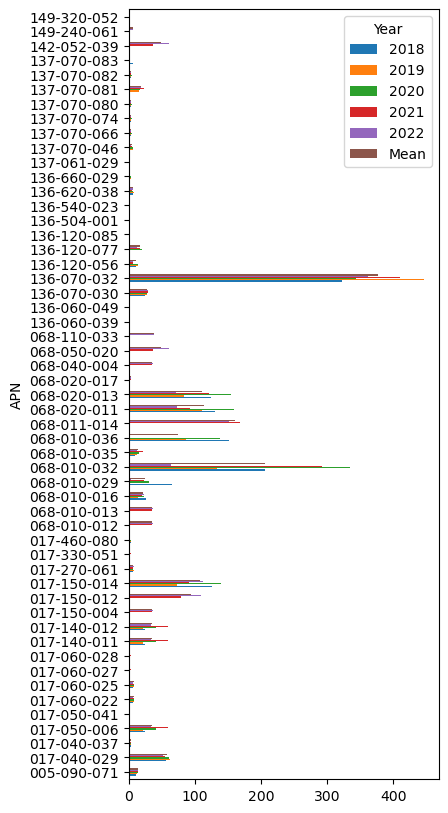

In [8]:
dfsum.plot.barh(figsize = (4,10))